## Image classification with Convolutional Neural Networks

## Introduction to our first task: 'State Farm Distracted Driver Detection'

We're going to try to create a model to enter the Dogs vs Cats competition at Kaggle. There are 25,000 labelled dog and cat photos available for training, and 12,500 in the test set that we have to try to label for this competition. According to the Kaggle web-site, when this competition was launched (end of 2013): "State of the art: The current literature suggests machine classifiers can score above 80% accuracy on this task". So if we can beat 80%, then we will be at the cutting edge as of 2013!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
PATH = "data/state/"
# PATH = "data/state/sample/"
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [6]:
torch.backends.cudnn.enabled

True

## First look at driver pictures

Our library will assume that you have *train* and *valid* directories. It also assumes that each dir will have subdirs for each class you wish to recognize (in this case, 'cats' and 'dogs').

In [8]:
os.listdir(PATH)

['test',
 'valid',
 'train',
 'imgs.zip',
 'sample_submission.csv.zip',
 'models',
 'results',
 'tmp',
 'driver_imgs_list.csv',
 'driver_imgs_list.csv.zip',
 'sample']

In [9]:
os.listdir(f'{PATH}valid')

['c1', 'c3', 'c0', 'c4', 'c5', 'c6', 'c9', 'c7', 'c8', 'c2']

In [10]:
files = os.listdir(f'{PATH}valid/c0')[:5]
files

['img_48499.jpg',
 'img_59868.jpg',
 'img_41417.jpg',
 'img_96307.jpg',
 'img_88085.jpg']

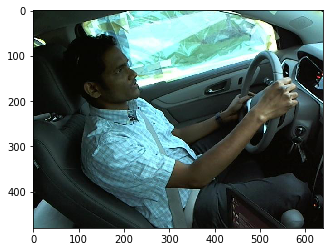

In [18]:
img = plt.imread(f'{PATH}valid/c0/{files[2]}')
plt.imshow(img);

Here is how the raw data looks like

In [13]:
img.shape

(480, 640, 3)

In [19]:
img[:4,:4]

array([[[36, 43, 36],
        [36, 43, 36],
        [35, 42, 35],
        [35, 42, 35]],

       [[34, 41, 34],
        [34, 41, 34],
        [34, 41, 34],
        [33, 40, 33]],

       [[33, 40, 33],
        [32, 39, 32],
        [31, 38, 31],
        [30, 37, 30]],

       [[31, 38, 31],
        [30, 37, 30],
        [28, 35, 28],
        [27, 34, 27]]], dtype=uint8)

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks). We'll be studying them in depth later, but for now we'll focus on using them effectively.

Here's how to train and evalulate a *dogs vs cats* model in 3 lines of code, and under 20 seconds:

In [15]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [16]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


epoch      trn_loss   val_loss   accuracy                
    0      2.118974   1.706303   0.406     
    1      1.462928   1.435697   0.509                    



[array([1.4357]), 0.5090000004768371]

How good is this model? Well, as we mentioned, prior to this competition, the state of the art was 80% accuracy. But the competition resulted in a huge jump to 98.9% accuracy, with the author of a popular deep learning library winning the competition. Extraordinarily, less than 4 years later, we can now beat that result in seconds! Even last year in this same course, our initial model had 98.3% accuracy, which is nearly double the error we're getting just a year later, and that took around 10 minutes to compute.

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

In [17]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 

In [18]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [19]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(1000, 10)

In [21]:
learn

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=10, bias=True)
  (7): LogSoftmax()
)

In [20]:
log_preds[:10]

array([[-1.69469, -4.69256, -5.67637, -2.02979, -0.53146, -3.5035 , -5.45187, -4.37584, -3.43154, -5.23073],
       [-0.489  , -4.04628, -2.81332, -3.39092, -5.13681, -3.71473, -2.68185, -4.52228, -3.06365, -2.12582],
       [-2.4658 , -3.13522, -1.03069, -4.881  , -4.58566, -2.8513 , -2.73113, -2.90666, -1.62431, -2.10045],
       [-0.59024, -5.11118, -5.41922, -3.8767 , -1.92441, -2.0455 , -4.49116, -2.97131, -2.88622, -3.85755],
       [-1.86497, -2.3278 , -5.32194, -3.66285, -4.70315, -1.81495, -4.76544, -5.21532, -3.70568, -0.68004],
       [-2.78609, -1.96738, -4.03157, -2.14641, -1.97012, -1.10594, -3.56856, -2.84966, -2.67393, -3.25747],
       [-1.4356 , -3.44389, -4.83228, -3.2592 , -1.04075, -1.85753, -4.52263, -3.25078, -2.15578, -4.70665],
       [-0.88788, -5.01433, -1.89347, -3.71824, -5.79235, -2.87917, -2.00927, -4.44661, -2.40515, -2.1918 ],
       [-1.57522, -3.43716, -5.58339, -2.26384, -3.69371, -0.72442, -4.76573, -3.25519, -3.19037, -2.89249],
       [-0.45909, -

In [22]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [69]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct), data.val_y, preds

In [70]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [71]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [72]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, correct_classes, title):
#     pdb.set_trace()
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    titles = ['Class:' + distraction_list[j] + ', Label: ' + str(j) +'\n'+', Prediction: ' +   ''.join(str(probs[i])) for i,j in zip(idxs, correct_classes)]
    print(title)
    return plots(imgs, rows=2, titles=titles, figsize=(16,8))

Correctly classified


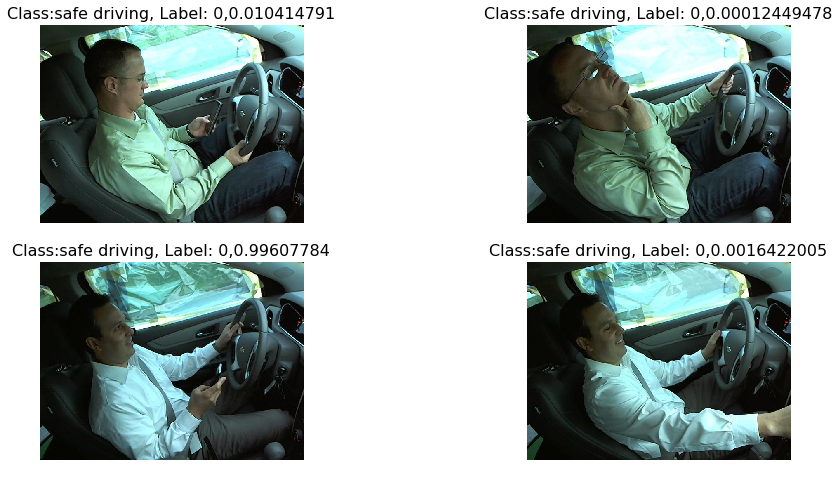

In [66]:
# 1. A few correct labels at random
plot_val_with_title(*rand_by_correct(True), "Correctly classified")

Incorrectly classified


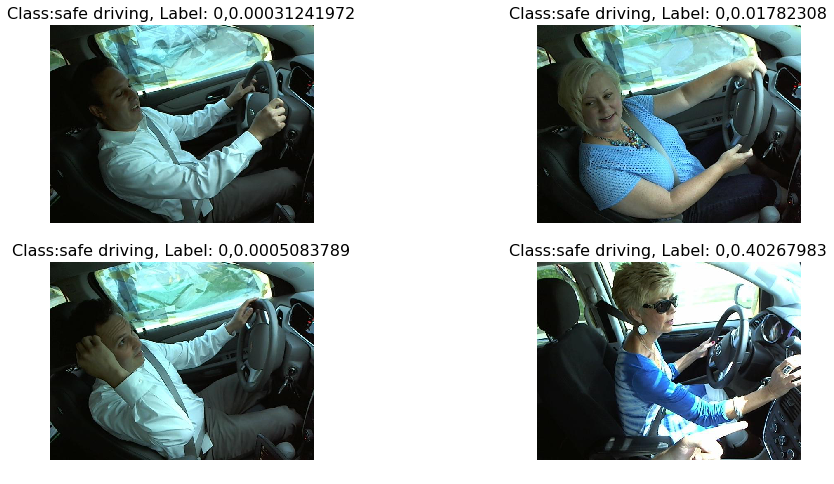

In [68]:
# 2. A few incorrect labels at random
plot_val_with_title(*rand_by_correct(False), "Incorrectly classified")

In [32]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [44]:
# The 10 classes to predict are:

distraction_classes = { 'c0': 'safe driving',
    'c1': 'texting - right',
    'c2': 'talking on the phone - right',
    'c3': 'texting - left',
    'c4': 'talking on the phone - left',
    'c5': 'operating the radio',
    'c6': 'drinking',
    'c7': 'reaching behind',
    'c8': 'hair and makeup',
    'c9': 'talking to passenger'}

In [50]:
distraction_list = [i for i in distraction_classes.values()]

In [51]:
distraction_list

['safe driving',
 'texting - right',
 'talking on the phone - right',
 'texting - left',
 'talking on the phone - left',
 'operating the radio',
 'drinking',
 'reaching behind',
 'hair and makeup',
 'talking to passenger']

Most correct safe driving


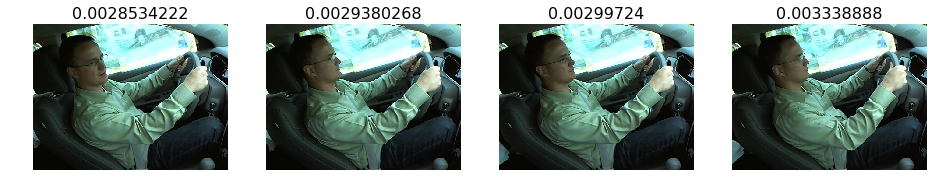

In [40]:
plot_val_with_title(most_by_correct(0, True), f"Most correct {distraction_classes['c0']}")

Most correct texting - right


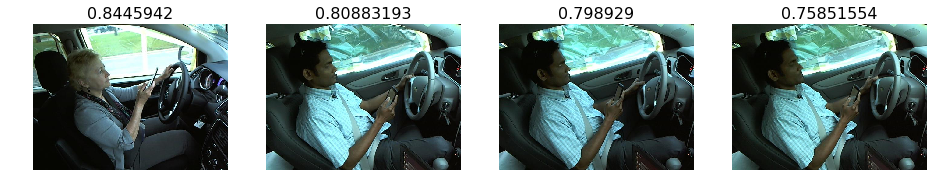

In [41]:
plot_val_with_title(most_by_correct(1, True), f"Most correct {distraction_classes['c1']}")

Most incorrect correct safe driving


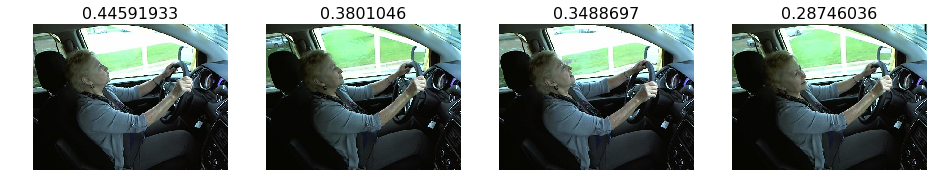

In [44]:
plot_val_with_title(most_by_correct(0, False), f"Most incorrect correct {distraction_classes['c0']}")

Most incorrect texting - right


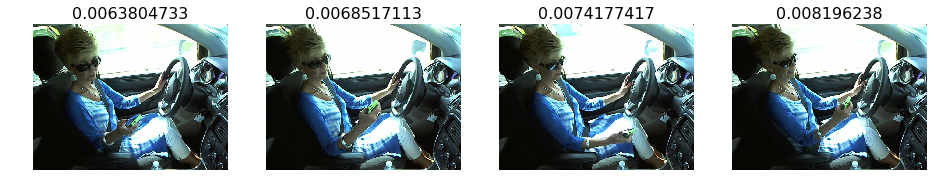

In [46]:
plot_val_with_title(most_by_correct(1, False), f"Most incorrect {distraction_classes['c1']}")

Most uncertain predictions


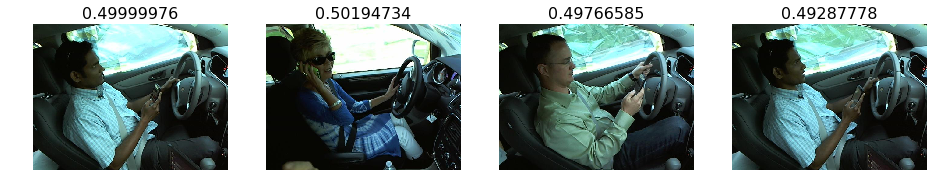

In [47]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [48]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [49]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   accuracy                 
    0      3.483239   343.539992 0.172     



Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

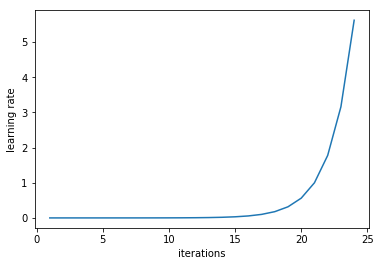

In [50]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

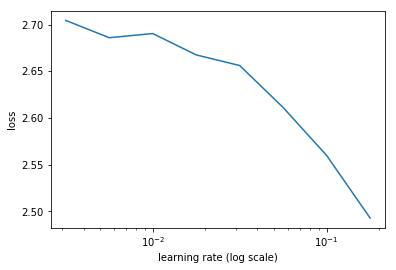

In [51]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

## VGG

### Data augmentation

In [6]:
transform = [RandomFlip(), RandomLighting(0.3, 0.5), RandomBlur(), RandomRotate(10)]

In [7]:
tfms = tfms_from_model(vgg16, sz, aug_tfms=transform, max_zoom=1.1)

In [66]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [67]:
get_augs().shape

(224, 224, 3)

In [68]:
ims = np.stack([get_augs() for i in range(6)])

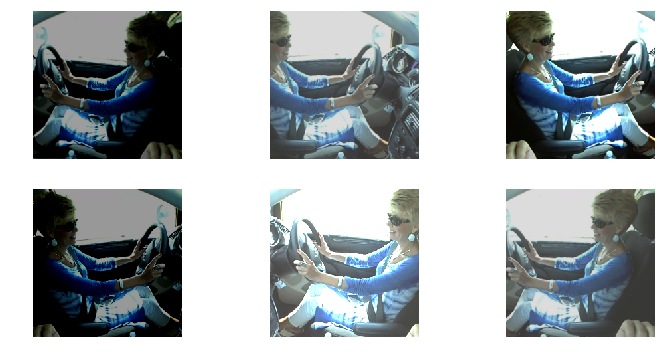

In [69]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [ ]:
arch=vgg16

data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

 34%|███▍      | 425/1246 [05:31<10:40,  1.28it/s]

KeyboardInterrupt: 

In [71]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.408917   1.218146   0.615046  



[array([1.21815]), 0.615046102263202]

In [72]:
learn.precompute=False

In [73]:
learn.fit(1e-2, 1, cycle_len=3, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                   
    0      1.018581   0.943441   0.688181  
    1      0.880804   0.899665   0.713956                    
    2      0.812615   0.870241   0.715633                    



[array([0.87024]), 0.7156328582903565]

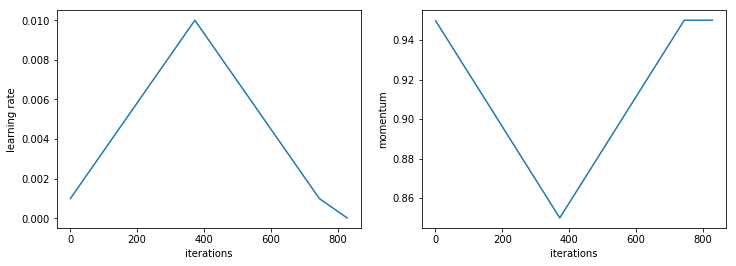

In [74]:
learn.sched.plot_lr()

In [75]:
learn.save('224_lastlayer')

In [76]:
learn.load('224_lastlayer')

### Fine-tuning and differential learning rate annealing

Make all layers trainable allows the model finetune the features from ImageNet images to this specific dataset.

In [77]:
learn.unfreeze()

In [78]:
lr=np.array([1e-4,1e-3,1e-2])

In [79]:
learn.fit(lr, 1, cycle_len=7, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                    
    0      0.310199   0.527283   0.810981  
    1      0.144947   0.536737   0.821668                    
    2      0.102326   0.483434   0.831517                     
    3      0.074566   0.487943   0.840319                     
    4      0.052358   0.50773    0.838223                     
    5      0.044954   0.48952    0.841157                     
    6      0.045148   0.485899   0.840528                     



[array([0.4859]), 0.8405280803944619]

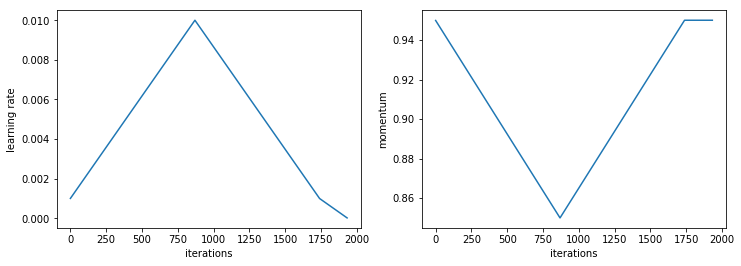

In [80]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [81]:
learn.save('224_all')

In [82]:
learn.load('224_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [9]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs, y)

0.8539396479463537

In [8]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
arch=vgg16
learn = ConvLearner.pretrained(arch, data, precompute=False)

learn.unfreeze()
learn.load('224_all')

In [13]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

### Clipping

In [26]:
probs_df = pd.DataFrame(probs)
probs_df.columns = ['c'+ str(i) for i in range(10)]
probs_df['img'] = [i[5:] for i in data.test_ds.fnames]

In [28]:
probs_df = probs_df.reindex_axis(['img'] + ['c'+ str(i) for i in range(10)],axis=1)

/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  """Entry point for launching an IPython kernel.


In [29]:
probs_df.to_csv('submission_vgg_16.csv',index=False,header=True)

In [44]:
clip_cols = ['c' + str(i) for i in range(10)]

In [66]:
# probs_df_clip_25 = probs_df[clip_cols].clip(0.25/10,0.975)
# probs_df_clip_50 = probs_df[clip_cols].clip(0.05/10,0.95)
# probs_df_clip_10 = probs_df[clip_cols].clip(0.01/10,0.99)
# probs_df_clip_25['img'] = [i[5:] for i in data.test_ds.fnames]
# probs_df_clip_10['img'] = [i[5:] for i in data.test_ds.fnames]
# probs_df_clip_50['img'] = [i[5:] for i in data.test_ds.fnames]
# probs_df_clip_25 = probs_df_clip_25.reindex_axis(['img'] + ['c'+ str(i) for i in range(10)],axis=1)
# probs_df_clip_50 = probs_df_clip_50.reindex_axis(['img'] + ['c'+ str(i) for i in range(10)],axis=1)
# probs_df_clip_10 = probs_df_clip_10.reindex_axis(['img'] + ['c'+ str(i) for i in range(10)],axis=1)
# probs_df_clip_25.to_csv('submission_vgg_16_clip_25.csv',index=False,header=True)
# probs_df_clip_50.to_csv('submission_vgg_16_clip_50.csv',index=False,header=True)
# probs_df_clip_10.to_csv('submission_vgg_16_clip_10.csv',index=False,header=True)
probs_df_clip_5 = probs_df[clip_cols].clip(0.005/10,0.995)
probs_df_clip_5['img'] = [i[5:] for i in data.test_ds.fnames]
probs_df_clip_5 = probs_df_clip_5.reindex_axis(['img'] + ['c'+ str(i) for i in range(10)],axis=1)
probs_df_clip_5.to_csv('submission_vgg_16_clip_5.csv',index=False,header=True)


/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  from ipykernel import kernelapp as app


In [58]:
probs_df_clip_50.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_49014.jpg,0.005,0.005,0.005000,0.005,0.950,0.005000,0.005,0.005000,0.021415,0.005
1,img_87917.jpg,0.005,0.005,0.039112,0.005,0.005,0.010101,0.005,0.380405,0.566119,0.005
2,img_69317.jpg,0.005,0.005,0.005000,0.005,0.005,0.005000,0.005,0.005000,0.950000,0.005
3,img_45984.jpg,0.005,0.005,0.005000,0.005,0.005,0.005000,0.950,0.005000,0.005000,0.005
4,img_24439.jpg,0.005,0.005,0.005000,0.005,0.005,0.005000,0.005,0.950000,0.005000,0.005


In [59]:
probs_df_clip_10.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_49014.jpg,0.001408,0.001000,0.001000,0.001,0.975976,0.001000,0.001000,0.001000,0.021415,0.001000
1,img_87917.jpg,0.001000,0.001114,0.039112,0.001,0.001000,0.010101,0.001628,0.380405,0.566119,0.001000
2,img_69317.jpg,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.001000,0.990000,0.001000
3,img_45984.jpg,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.990000,0.001000,0.001000,0.001000
4,img_24439.jpg,0.001000,0.001000,0.001000,0.001,0.001000,0.001000,0.001000,0.990000,0.001000,0.002274


In [67]:
# !kaggle competitions submit -c state-farm-distracted-driver-detection -f 'submission_vgg_16_clip_5.csv' -m 'VGG16_bn finetune all regular'
# !kaggle competitions submit -c state-farm-distracted-driver-detection -f 'submission_vgg_16_clip_25.csv' -m 'VGG16_bn finetune all regular'
# !kaggle competitions submit -c state-farm-distracted-driver-detection -f 'submission_vgg_16_clip_50.csv' -m 'VGG16_bn finetune all regular'
# !kaggle competitions submit -c state-farm-distracted-driver-detection -f 'submission_vgg_16_clip_10.csv' -m 'VGG16_bn finetune all regular'

Successfully submitted to State Farm Distracted Driver Detection

In [37]:

!kaggle competitions submit -c state-farm-distracted-driver-detection -f 'submission_vgg_16.csv' -m 'VGG16_bn finetune all regular'

Successfully submitted to State Farm Distracted Driver Detection

In [68]:
!kaggle competitions submissions -c state-farm-distracted-driver-detection

fileName                       date                 description                    status    publicScore  privateScore  
-----------------------------  -------------------  -----------------------------  --------  -----------  ------------  
submission_vgg_16_clip_5.csv   2018-05-11 18:32:37  VGG16_bn finetune all regular  complete  0.41032      0.36309       
submission_vgg_16_clip_10.csv  2018-05-11 18:29:38  VGG16_bn finetune all regular  complete  0.41150      0.36469       
submission_vgg_16_clip_50.csv  2018-05-11 18:29:31  VGG16_bn finetune all regular  complete  0.42981      0.38600       
submission_vgg_16_clip_25.csv  2018-05-11 18:29:24  VGG16_bn finetune all regular  complete  0.54472      0.51029       
submission_vgg_16_clip_50.csv  2018-05-11 18:28:16  VGG16_bn finetune all regular  complete  0.40969      0.36280       
submission_vgg_16_clip_25.csv  2018-05-11 18:28:08  VGG16_bn finetune all regular  complete  0.40969      0.36280       
submission_vgg_16_clip_50.csv  2

In [ ]:
!kaggle competitions -c state-farm-distracted-driver-detection -f file -m 'VGG16_bn finetune all regular'
!kaggle competitions -c state-farm-distracted-driver-detection -f file -m 'VGG16_bn finetune all clip .25'

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [11]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [12]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[465  10   0  17   0   3   0   0  47  44]
 [  3 476   0   2   0   0   0   0   1   0]
 [  0   0 459   1   0   0   0   0  13   6]
 [  0   3   0 465   1   0   0   0   2   0]
 [  1   0   1   2 452   0   0   0   2   1]
 [  2  18   1   2   0 389   9  12  37   2]
 [  0   0   0   0   0   0 449   0  25   0]
 [  1   1   0   0   0   0   0 423  24   2]
 [  1   1  23   0   0   0  11  76 316   0]
 [172  25   0   0   1   5   0   3  83 181]]


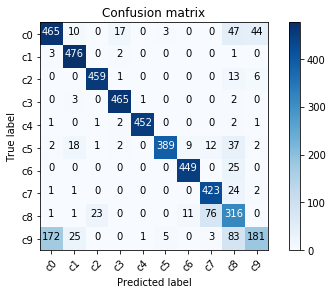

In [13]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [14]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect Drivers ")

NameError: name 'plot_val_with_title' is not defined

In [15]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

NameError: name 'plot_val_with_title' is not defined

## Review: easy steps to train a world-class image classifier

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting

## Resnet

In [28]:
transform = [RandomFlip(), RandomLighting(0.3, 0.5), RandomBlur(), RandomRotate(10)]

In [29]:
arch=resnet34

In [30]:
tfms = tfms_from_model(arch, sz, aug_tfms=transform, max_zoom=1.1)

In [31]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [32]:
get_augs().shape

(224, 224, 3)

In [33]:
ims = np.stack([get_augs() for i in range(6)])

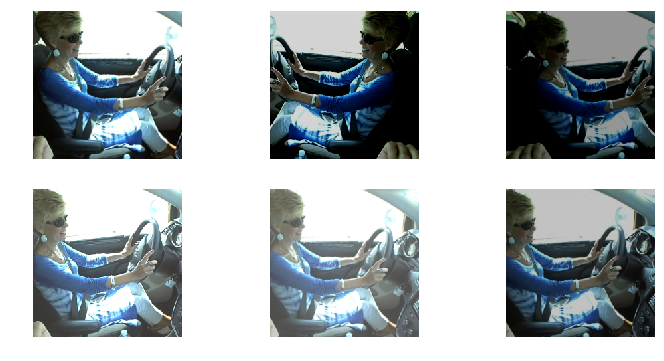

In [34]:
plots(ims, rows=2)

Let's create a new `data` object that includes this augmentation in the transforms.

In [43]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [44]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                    
    0      0.440333   1.310286   0.597024  



[array([1.31029]), 0.5970243084785425]

In [45]:
learn.precompute=False

In [46]:
learn.fit(1e-2, 1,wds=1e-5, cycle_len=3, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                    
    0      0.9615     1.074861   0.672255  
    1      0.832302   1.028836   0.678122                    
    2      0.755232   1.02009    0.685876                    



[array([1.02009]), 0.6858759429508763]

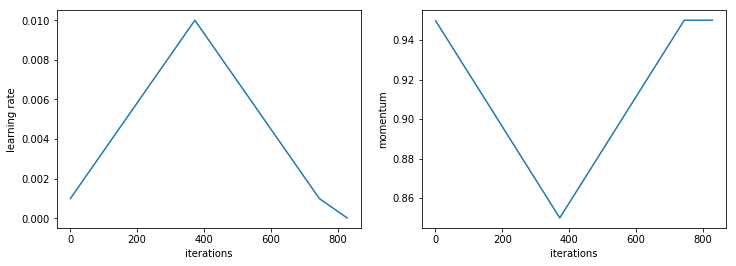

In [47]:
learn.sched.plot_lr()

In [48]:
learn.save('224_lastlayer_res')

In [49]:
learn.load('224_lastlayer_res')

### Fine-tuning and differential learning rate annealing

Make all layers trainable allows the model finetune the features from ImageNet images to this specific dataset.

In [50]:
learn.unfreeze()

In [51]:
lr=np.array([1e-4,1e-3,1e-2])

In [59]:
learn.fit(lr, 1, wds=1e-5,cycle_len=7, use_clr_beta=(10,10,0.95,0.85))

epoch      trn_loss   val_loss   accuracy                    
    0      0.295295   0.718797   0.771584  
    1      0.137682   0.68181    0.793378                    
    2      0.091578   0.7363     0.805742                     
    3      0.058666   0.757935   0.802598                     
    4      0.047319   0.73258    0.812657                     
    5      0.03439    0.776869   0.812657                     
    6      0.033599   0.798283   0.805742                     



[array([0.79828]), 0.8057418272261447]

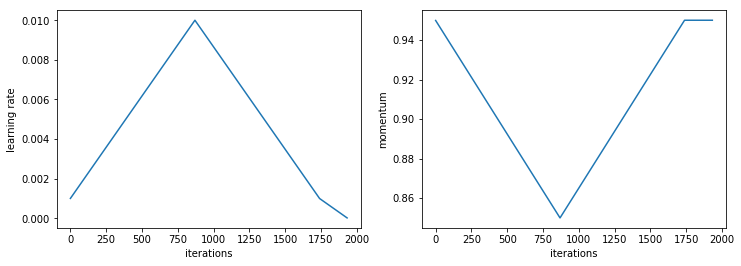

In [60]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [61]:
learn.save('224_all_res')

In [62]:
learn.load('224_all_res')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy_np(probs, y)

 75%|███████▌  | 3/4 [02:26<00:48, 48.96s/it]